# VegasAfterglow Integration with Redback Tutorial

This notebook demonstrates the full capabilities of using VegasAfterglow models within redback for GRB afterglow analysis.

VegasAfterglow provides high-performance C++ implementations (~1-10ms per lightcurve) with advanced physics including:
- Multiple jet structures (tophat, Gaussian, power-law, step, etc.)
- Unified ISM/Wind/Hybrid medium treatment
- Reverse shocks
- Synchrotron self-Compton (SSC)
- Magnetar energy injection

Combined with redback's powerful features:
- Non-detections handling
- Complex likelihoods (GP, mixture models)
- Multi-wavelength and spectral analysis
- Combined models (kilonova + afterglow, etc.), with over 150 inbuilt models.
- Population synthesis
- A large library of samplers

In [1]:
import redback
import bilby
import numpy as np
import matplotlib.pyplot as plt
from redback.simulate_transients import SimulateGenericTransient
%matplotlib inline

01:41 bilby INFO    : Running bilby version: 2.7.1
01:41 redback INFO    : Running redback version: 1.13.1


## 1. Simulate GRB Afterglow Data

We'll simulate a tophat jet expanding into an ISM environment.

In [2]:
# Set up parameters for a tophat jet in an ISM
parameters = {
    'redshift': 0.5,
    'thv': 0.3,         # viewing angle in radians  
    'loge0': 52.5,      # log10 isotropic energy [erg]
    'thc': 0.2,         # jet core angle in radians
    'lognism': 0.0,     # log10 ISM density [cm^-3]
    'loga': -10.0,      # log10 wind parameter (very small = pure ISM)
    'p': 2.2,           # electron power-law index
    'logepse': -1.0,    # log10 electron energy fraction
    'logepsb': -2.0,    # log10 magnetic energy fraction
    'g0': 300.0         # initial Lorentz factor
}

# Generate synthetic observations at optical frequency
times = np.logspace(0, 2, 30)  # 1 to 30 days
model_kwargs = {'output_format': 'flux_density', 'frequency': [5e14, 2e17, 5e9]}

# Let's use one of the simplest simulators in Redback
simulator = SimulateGenericTransient(
    model='vegas_tophat',
    parameters=parameters,
    times=times,
    data_points=40,
    multiwavelength_transient=True, # so it repeats frequencies/bands 
    model_kwargs=model_kwargs,
    noise_term=0.1
)

print(f"Generated {len(simulator.data)} synthetic observations")
simulator.data.head()

Generated 40 synthetic observations


,time,frequency,true_output,output,output_error
0,1.172102,5.000000e+09,0.024573,0.022627,0.002457
1,1.172102,2.000000e+17,0.000015,0.000015,0.000002
2,1.373824,5.000000e+14,0.004873,0.004224,0.000487
3,1.887392,5.000000e+09,0.070251,0.061738,0.007025
4,2.212216,5.000000e+09,0.090690,0.096768,0.009069


## 2. Load Data into Redback Afterglow Object

In [ ]:
# Create Afterglow object from simulated data
afterglow = redback.transient.Afterglow(
    name='GRB_synthetic',
    data_mode='flux_density',
    time=simulator.data['time'].values,
    flux_density=simulator.data['output'].values,
    flux_density_err=simulator.data['output_error'].values,
    frequency=simulator.data['frequency'].values)

print(f"Loaded afterglow object: {afterglow.name}")
print(f"Data mode: {afterglow.data_mode}")
print(f"Number of observations: {len(afterglow.x)}")

# Plot the data
afterglow.plot_data()
plt.show()

In [ ]:
redback.priors.get_priors(model='vegas_tophat')

## 3. Maximum Likelihood Estimation

Before running full Bayesian inference, let's find the maximum likelihood solution quickly.

In [ ]:
# Get priors for vegas_tophat
priors = redback.priors.get_priors(model='vegas_tophat')

# to help the sampling for speed we will just fix a few parameters
for key in ['redshift', 'thv', 'loga', 'logepse', 'logepsb', 'g0', 'lognism']:
    priors[key] = parameters[key]


# Set up likelihood, we do not normally need to do this unless using custom likelihoods. 
# However, here, we show how we can use this likelihood to do simple MLE estimation.
# This means we must pass a prior and a fiducial draw from that prior. 
model_kwargs = {'output_format': 'flux_density', 'frequency': afterglow.frequency}

likelihood = redback.likelihoods.GaussianLikelihood(
    x=afterglow.x,
    y=afterglow.y,
    sigma=afterglow.y_err,
    function=redback.model_library.all_models_dict['vegas_tophat'],
    kwargs=model_kwargs, priors=priors, fiducial_parameters=priors.sample())


# Find maximum likelihood estimate
result_mle = likelihood.find_maximum_likelihood_parameters(iterations=5,)

injection_parameters = {}
for key in ['thc', 'loge0', 'p']:
    injection_parameters[key] = parameters[key]

print("\nMaximum likelihood parameters:")
for key in injection_parameters.keys():
    if key in result_mle:
        print(f"  {key}: {result_mle[key]:.3f} (true: {parameters[key]:.3f})")

## 4. Full Bayesian Parameter Estimation

In [ ]:
# Run full Bayesian sampling
result = redback.fit_model(
    model='vegas_tophat',
    sampler='nestle', # we can use a range of different samplers here. 
    likelihood=likelihood,
    model_kwargs=model_kwargs,
    injection_parameters=injection_parameters,
    nlive=100,
    transient=afterglow,
    prior=priors,
    sample='rslice',
    clean=False, plot=False)

print("Sampling complete!")

In [ ]:
# Plot corner plot
result.plot_corner()

In [ ]:
# Plot lightcurve fit with posterior samples
result.plot_lightcurve(random_models=50)

There's plenty of other functionality you could exploit, have a look at the other examples!

## 5. Compare with Other Redback Afterglow Models

Let's compare VegasAfterglow's tophat model with other implementations in redback.

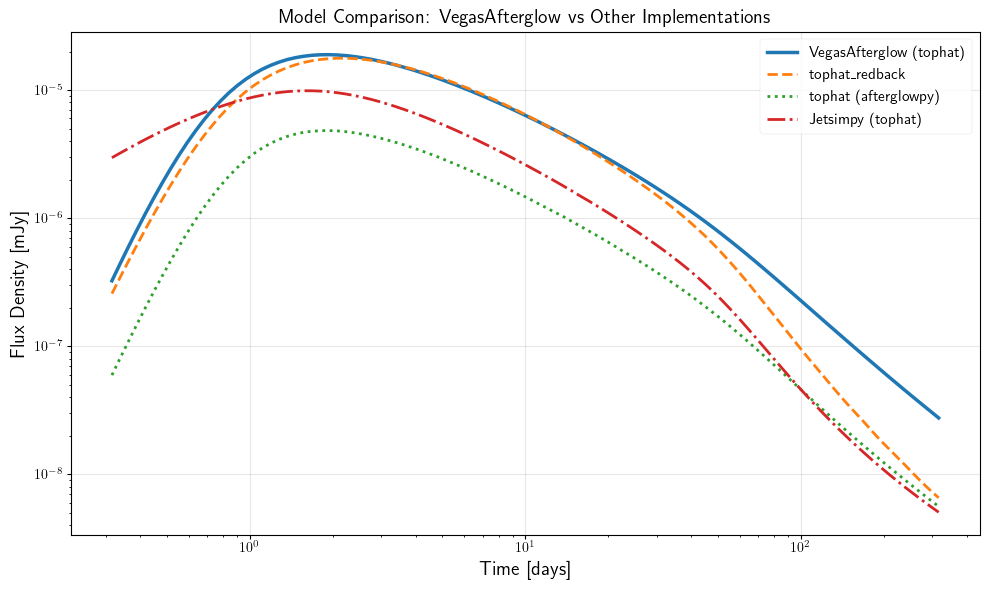

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot vegas model
time_plot = np.logspace(-0.5, 2.5, 100)
vegas_flux = redback.model_library.all_models_dict['vegas_tophat'](
    time=time_plot, **parameters, frequency=2e17)
ax.plot(time_plot, vegas_flux, label='VegasAfterglow (tophat)', linewidth=2.5, color='C0')

# Compare with tophat_redback
tophat_redback_params = {
    'redshift': parameters['redshift'],
    'thv': parameters['thv'],
    'loge0': parameters['loge0'],
    'thc': parameters['thc'],
    'logn0': parameters['lognism'],
    'p': parameters['p'],
    'logepse': parameters['logepse'],
    'logepsb': parameters['logepsb'],
    'g0': parameters['g0'],
    'xiN': 1.0
}
tophat_redback_flux = redback.model_library.all_models_dict['tophat_redback'](
    time=time_plot, **tophat_redback_params, frequency=2e17, output_format='flux_density')
ax.plot(time_plot, tophat_redback_flux, '--', label='tophat_redback', linewidth=2, color='C1')
tophat_params = {
        'redshift': parameters['redshift'],
        'thv': parameters['thv'],
        'loge0': parameters['loge0'],
        'thc': parameters['thc'],
        'logn0': parameters['lognism'],
        'p': parameters['p'],
        'logepse': parameters['logepse'],
        'logepsb': parameters['logepsb'],
        'g0':parameters['g0'], 
        'ksin':1}
tophat_flux = redback.model_library.all_models_dict['tophat'](
    time=time_plot, **tophat_params, frequency=2e17, output_format='flux_density')
ax.plot(time_plot, tophat_flux, ':', label='tophat (afterglowpy)', linewidth=2, color='C2')

# Compare with jetsimpy if available
try:
    jetsimpy_params = {
        'redshift': parameters['redshift'],
        'thv': parameters['thv'],
        'loge0': parameters['loge0'],
        'thc': parameters['thc'],
        'nism': 10**parameters['lognism'],
        'A': 10**parameters['loga'],
        'p': parameters['p'],
        'logepse': parameters['logepse'],
        'logepsb': parameters['logepsb'],
        'g0': parameters['g0']
    }
    jetsimpy_flux = redback.model_library.all_models_dict['jetsimpy_tophat'](
        time=time_plot, **jetsimpy_params, frequency=2e17, output_format='flux_density')
    ax.plot(time_plot, jetsimpy_flux, '-.', label='Jetsimpy (tophat)', linewidth=2, color='C3')
except Exception as e:
    print(f"Jetsimpy comparison skipped: {e}")

ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('Flux Density [mJy]', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_title('Model Comparison: VegasAfterglow vs Other Implementations', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Advanced Redback Features

Redback and VegasAfterglow together provide extensive capabilities for GRB analysis:

### Non-detections

Redback can incorporate upper limits alongside detections in your fits. This is crucial for constraining early-time or late-time behavior.

### Multiple Jet Structures

VegasAfterglow provides various jet structures and all are available via redback via:

In [ ]:
print("Available VegasAfterglow models in redback:")
vegas_models = [m for m in redback.model_library.all_models_dict.keys() if 'vegas_' in m]
for model in vegas_models:
    print(f"  - {model}")

### Reverse Shocks and SSC

Enable advanced physics with simple kwargs:

In [ ]:
# Example with reverse shock
advanced_kwargs = {
    'output_format': 'flux_density',
    'frequency': 5e14,
    'reverse_shock': True,
    'reverse_logepse': -0.5,  # Different microphysics in reverse shock
    'reverse_logepsb': -1.5,
    'reverse_p': 2.5,
    'ssc': True,  # Enable synchrotron self-Compton
    'kn': True    # Klein-Nishina corrections
}

print("Advanced physics options:")
print("  - reverse_shock: Include reverse shock emission")
print("  - ssc: Synchrotron self-Compton")
print("  - kn: Klein-Nishina corrections")
print("  - magnetar energy injection: Add magnetar_L0, magnetar_t0, magnetar_q")
print("  - Everything handled through optional keyword arguments")

### Multi-wavelength and Spectral Analysis

Redback can fit multi-wavelength data simultaneously and perform spectral analysis:

### Combined Models

Redback allows combining different transient models:

### Complex Likelihoods

Redback supports various likelihood models beyond simple Gaussian:

## Summary

This tutorial demonstrated:

1. **Simulating** GRB afterglow data with VegasAfterglow models
2. **Loading** data into redback's Afterglow object
3. **Maximum likelihood** parameter estimation
4. **Full Bayesian inference** with nested sampling
5. **Comparing** different afterglow model implementations
6. **Advanced features** available in the redback + VegasAfterglow ecosystem

### Key Benefits:

- **Speed**: VegasAfterglow provides ~1ms evaluations (100-1000x faster than Python)
- **Physics**: Unified medium treatment, reverse shocks, SSC, magnetar injection
- **Flexibility**: Multiple jet structures and ISM/wind environments
- **Integration**: Full redback ecosystem (non-detections, multi-wavelength, combined models)

### Next Steps:

- Explore other jet structures (gaussian, powerlaw, step, etc.)
- Try wind or hybrid medium environments  
- Enable reverse shocks and SSC for more realistic modeling
- Fit real GRB data from your favorite telescope!

Check out the other redback examples for more advanced workflows!